## Classify Emails beyond spams - using K-Means Clustering 

### This notebook shows the implementation of K-Means clustering without WSD i.e. Word Sense Disambiguation. The synonyms and hypernyms are not included here. Level 1

### Final Project - Riti Chakraborty

In [1]:
#Riti Chakraborty

#importing the required libraries
import scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
#library for tf-idf vector
from sklearn.feature_extraction.text import TfidfVectorizer


import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import CountVectorizer
import numpy
from numpy import nan

#for flattening lists
from itertools import chain

#To handle warning
import warnings
warnings.filterwarnings('ignore')

#For implementing Natural Language Processing approaches.
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

#For using Regular expression
import re

#For Handling Strings
import string
#For plotting data
import matplotlib.pyplot as plt


#For implementing word sense disambiguation
from nltk.corpus import wordnet as wn
from wordsegment import load, segment

#Important to call load()
load()

#Importing Libraries required for arithmatic operations
from operator import mul 
from operator import add

#For LDA Implementation # Importing Gensim
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora

#For evaluation Topic models formed
from gensim.models import CoherenceModel

#For visualising LDA Output
import pyLDAvis
import pyLDAvis.gensim 

In [2]:
#This file read here, has been generated by the data_preprocess.ipynb.
data_subset=pd.read_csv("../exported_tables/data_subset.csv")

#converting the data in the dataframe into str type
data_subset = data_subset.astype(str) 

#retaining proper index
data_subset=data_subset.reset_index(drop=True)

num_of_rows=len(data_subset.index)
print("Total Number of rows: ",num_of_rows)

# Converting each row to list of lists
list1=data_subset.values.tolist()
list2=[]

# Converting each sublist into string and storing it in list2
for i in range(0, len(list1)):
    list2.append(' '.join(map(str, list1[i])))


Total Number of rows:  1135


### Function for Stop words removal

In [3]:
def stopword_remove(l2):
    fil_list2=[]
    for sent in l2:
        stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","hibody", "yourself", "spam","body","yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
        word_tokens = word_tokenize(sent.lower())
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []

        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)

        fil_list2.append(' '.join(filtered_sentence))
    return fil_list2

#calling the Stopword_remove function and the storing the results returned in a list
fil_list2=stopword_remove(list2)

### Function for Punctuation Removal

In [4]:
# Defining a function to remove punctuation
def no_punctuation(my_str):
    punctuations = '''!()-[]{};:'"\\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
        else:
            no_punct = no_punct + " "
    return no_punct

### Function for Segementing words 

In [5]:
def seg_syn(l1):
    wordlist2=[]
    wordlist2.append(no_punctuation(l1).split())
    seg=[]
    for w in wordlist2:
        #Removing Integers
        no_integers = [x for x in w if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        pure_string=[x for x in no_integers if not any(c.isdigit() for c in x)]
        
        #Word segmentation
        for s in pure_string:
            seg.append(segment(s))
            
    #flattening the list
    flat_seg_list = [item for sublist in seg for item in sublist]
    
    return flat_seg_list


In [6]:
# Calling the function seg_syn()
list2_syn=[]
for l in fil_list2:
    #Storing the synonyms and the hypernyms part returned from the previous function
    seg_list=seg_syn(str(l))
    list2_syn.append(seg_list)


#flattening
flat_list_syn=len(list(chain(*list2_syn)))


#Converting back to strings
flat_list2_syn=[]
for ls in list2_syn:
    flat_list2_syn.append(' '.join(list(set(ls))))

#Storing the values as a dataframe
df_flatlist=pd.DataFrame(flat_list2_syn)
df_flatlist["Index"]=df_flatlist.index

#removing the punctuation marks
no_punct_flat_list2_syn=[no_punctuation(i) for i in flat_list2_syn]


## K-Means Clustering (Unsupervised Approach)


In [7]:
#genrating the tf-idf matrix
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

#here X is in the form of ndarray
X = vect.fit_transform(no_punct_flat_list2_syn)

#Terms in overall dataset
terms = vect.get_feature_names()

#Computing the distances between the data points
distance_cos = 1 - cosine_similarity(X)


### Using PCA for Visualising the spread of data points

Note: PCA has been used only for the visualisation purpose. 

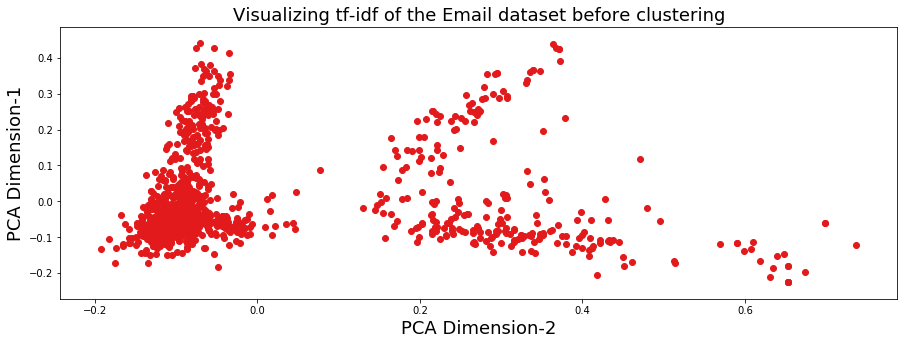

In [8]:
#converting tf idf ndarray to matrix form 
random.seed(3425)
X_matrix=X.todense()
X_matrix.shape

#setting the size of the figure
plt.rc('figure', figsize=(15, 5))

#converting nd array to matric form
X_dense = X.todense()

#reducing the dimensions to 2
coordinates = PCA(n_components=2).fit_transform(X_dense)

#Plotting the data
plt.scatter(coordinates[:, 0], coordinates[:, 1], c='#e31a1c')
plt.title("Visualizing tf-idf of the Email dataset before clustering",fontsize=18)
plt.xlabel('PCA Dimension-2', fontsize=18)
plt.ylabel('PCA Dimension-1', fontsize=18)
plt.savefig('../results_dendrograms_kmeans_visualisation/kmeansL1.jpg')


### Approaches used in determining the Right k i.e. no. of Clusters.
1. Elbow method
2. Silhouette Coefficient

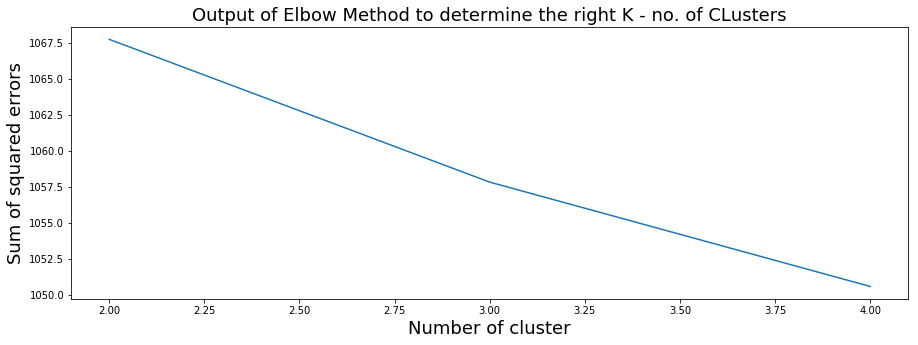

In [9]:
#Setting a random seed.
#this is basically because kmeans start by chosing random centroid that would give different results at each run. In order to avoid that and
#generate consistent outputs, random.seed or random_state is necessary.
random.seed(3425)

#Elbow Method
sum_squared_err = {}

#passing a range(2,5) of value for determining the optimal k 
for k in range(2, 5):
    
    # executing Kmeans in loop
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=3425).fit(X)
    
    #.inertia is used to find the sum of distances of samples to their closest cluster centroids i.e. sum of squared error
    sum_squared_err[k] = kmeans.inertia_ 
    
#Plotting the graph generated
plt.figure()
plt.plot(list(sum_squared_err.keys()), list(sum_squared_err.values()))
plt.title("Output of Elbow Method to determine the right K - no. of CLusters",fontsize=18)
plt.xlabel("Number of cluster", fontsize=18)
plt.ylabel("Sum of squared errors", fontsize=18)
plt.savefig('../results_dendrograms_kmeans_visualisation/elbow_kmeansL1.jpg')

In [10]:
random.seed(3425)

#Silhouette Coefficient
from sklearn.metrics import silhouette_score

for k in range(2, 5):
    kmeans = KMeans(n_clusters=k,  max_iter=500, random_state=3425).fit(X)
    label = kmeans.labels_
    silhouette_coeff = silhouette_score(X, label, metric='euclidean')
    print(" The Silhouette Coefficient Calculated is = ",silhouette_coeff, " For K = ",k)

 The Silhouette Coefficient Calculated is =  0.020747807012175965  For K =  2
 The Silhouette Coefficient Calculated is =  0.018011789178754147  For K =  3
 The Silhouette Coefficient Calculated is =  0.023530014606477547  For K =  4


The optimal number of clusters returned by the above two method is 3 and 4 respectively. Silhouette method is more ambivalent in deciding the number of cluster. Therefore we proceed with k=3 as returned by the elbow method. However, we can infer from the values returned by silhouette coefficient(which are near 0) that the clusters are very close to each other's boundary.

#### Ref: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

### Defining K - Means Function

In [11]:
def k_means(no_of_cluster):
    n_clusters = no_of_cluster

    #Calling the function Kmeans from sklearn library    
    clf = KMeans(n_clusters=n_clusters, max_iter=500, init='k-means++', n_init=1, random_state=3425)
    

    #Storing fitted labels
    labels = clf.fit_predict(X)
    
    #Setting seed
    random.seed(3425)

    no_of_emails_in_current_cluster=[]
    for cl in range(0,n_clusters):
        no_of_emails_in_current_cluster.append(list(labels).count(cl))
    centroids = clf.cluster_centers_

    
    return centroids,labels,clf,no_of_emails_in_current_cluster

### Calling the k_means Function defined above 

In [12]:
#Calling k_means function
tuple_output=k_means(3)

#Segregating the values returned by the function and storing them in variables

#Labels
labels=tuple_output[1]

#classification model used for visualisation
clf=tuple_output[2]

#number of emails in each cluster
no_of_emails_in_cluster=tuple_output[3]

#Centroid
centroid_s=tuple_output[0]

#Transposing the Matrix for display purpose
centroids_transpose=centroid_s.transpose()

#The centroids of each cluster are a set of td-idf values of the terms.
#print(pd.DataFrame(centroids_transpose))

### Extracting Top n terms from each cluster.

#### here, top 5 terms from each cluster has been displayed


In [13]:
#converting centroid list to a dataframe
df_centroids_transpose=pd.DataFrame(centroids_transpose)

#adding the terms to its corresponding centroid values
df_centroids_transpose['terms']=terms

#finding the dimensions of the new dataframe with centroids and terms 
size_df_centroids_transpose=df_centroids_transpose.shape

#Finding out the top 5 terms from each cluster
no_of_cols=size_df_centroids_transpose[1]
no_of_cols
for i in range(0,(no_of_cols-1)):
    print("Top 5 terms in cluster number ", i)
    print(df_centroids_transpose.nlargest(5, i)['terms'])

Top 5 terms in cluster number  0
681     mining
233         cs
762        org
742    october
549       june
Name: terms, dtype: object
Top 5 terms in cluster number  1
1128    viagra
793     pfizer
52       april
718        net
1002     store
Name: terms, dtype: object
Top 5 terms in cluster number  2
548         july
74        august
943    september
386       friday
644         mail
Name: terms, dtype: object


# Visualising Kmeans Cluster using PCA


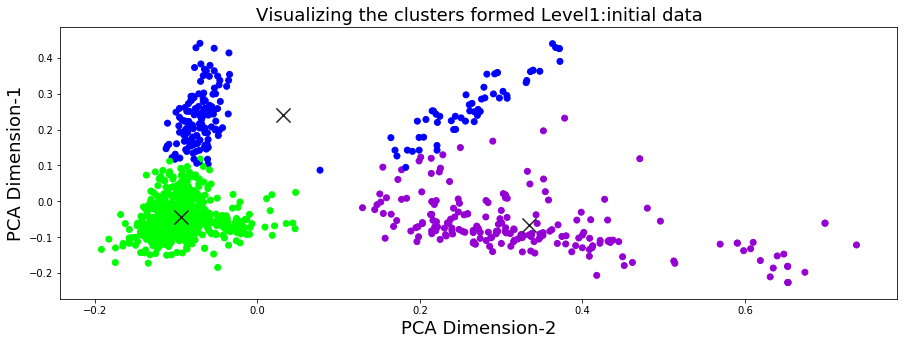

In [14]:
random.seed(1234)

pca = PCA(n_components=2).fit(X_dense)

#Defining a list of colors to be used in the visualisation. Different colour indicates different clusters
label_colors = ["#9400D3", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000",  "#4B0082","#FC6514"]

#Assigning distinct colors to the labels obtained
colors = [label_colors[i] for i in labels]

#Plotting the data
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=colors)

# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)


plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='x', s=200, linewidths=1, c='#252525')
plt.title("Visualizing the clusters formed Level1:initial data", fontsize=18)
plt.xlabel('PCA Dimension-2', fontsize=18)
plt.ylabel('PCA Dimension-1', fontsize=18)

#Exporting as image
plt.savefig('../results_dendrograms_kmeans_visualisation/kmeans_cls_L1.jpg')
plt.show()

### Precision, Recall and F-Value

In [15]:
#adding the labels returned by kmeans to each of the emails in the data_subset data frame.
data_subset=data_subset.reset_index(drop=True)
data_subset['labels_kmeans']=labels
data_subset=data_subset.sort_values('labels_kmeans')

#Renaming the dataframe
kmeans_result=data_subset
kmeans_clust = kmeans_result.groupby(by='labels_kmeans')

#grouping the emails depending on their labels
df_cluster_length=kmeans_result.groupby(['labels_kmeans']).size().to_frame(name = 'No_of_Emails_each_cluster').reset_index()
print(df_cluster_length)
#Grouping by cluster labels and Extracting Cluster types
cluster_types=len(df_cluster_length['labels_kmeans'].tolist())

   labels_kmeans  No_of_Emails_each_cluster
0              0                        195
1              1                        188
2              2                        752


### Extracting cluster wise data from the main dataset.

In [16]:
# Storing the Labels
kmeans_op = pd.DataFrame(labels)


#Performing join on the datsets
kmeans_result=kmeans_result.sort_values(by='labels_kmeans')

#Grouping by cluster labels
kmeans_clust = kmeans_result.groupby(kmeans_result['labels_kmeans'])


#Extracting Cluster types
cluster_types=list(set(kmeans_result['labels_kmeans']))
print("Cluster types:",cluster_types)

#Creating a list of Dataframes for each cluster
list_df_km=[]
for i in cluster_types:

#Displaying Clusterwise
    print("Cluster:", i)
    print()
    list_df_km.append(kmeans_clust.get_group(i))

Cluster types: [0, 1, 2]
Cluster: 0

Cluster: 1

Cluster: 2



## Defining a function that would calculate the Precision, Recall and the F- Value


### Precision = number of emails having the term in a cluster / number of emails in the cluster 

### Recall = number of emails having the term in a cluster / total number of emails having the term 

### F- Measure /F-Value = 2*[(precision * recall) / (precision + recall)]

In [17]:
def function_PRF(Index):
    km_data_1=list_df_km[Index].values.tolist()
    
    #Precision denominator
    P_D=no_of_emails_in_cluster[Index]
    
    pre_pros_emails=[]
    k_updated=[]
    for k in km_data_1:
        remo_digit=[]
        for item in k:
            if type(item) == int:
                item=None
                remo_digit.append(item)
            else:
                remo_digit.append(item)

        #Filtering out None
        str_list = list(filter(None, remo_digit))

        #Removing Punctuation
        no_punct=[no_punctuation(str(i)) for i in str_list]

        #Tokenizing the strings
        split_str=list(chain(*[i.split() for i in no_punct]))

        #Word Segmentation
        seg_split_str=list(chain(*[segment(j) for j in split_str]))
    
        no_stop_word=stopword_remove(seg_split_str)

        #Removing words with length less than  or equal to 3
        clean_str=[(re.sub(r'\b\w{1,3}\b', '', c)) for c in no_stop_word]

        #Stripping Whitespace if any
        km_to_empty = [x.strip() for x in clean_str]
        km_clean_list = list([x for x in km_to_empty if x])

        #Storing
        k_updated.append(km_clean_list)

        #Calculating Frequency of Terms
        Term_freq_each_email = Counter(km_clean_list).most_common()



    #Calculating term freq in current cluster
    Term_freq=Counter(list(chain(*k_updated))).most_common()

    #Converting segmented emails into strings
    k_updated_emails=[' '.join(ka) for ka in k_updated]
    pre_pros_emails.append(k_updated_emails)


    #Extracting Terms from tuple
    terms_=[t[0] for t in Term_freq]

    ##################Calculating Precision and Recall##########################################
    numerator_P_R=[]
    recall_den=[]
    for t_ in terms_:
        count_email_with_a_term=0
        count_email_with_a_term_in_all_cluster=0

        #Number of Emails with term t in the current cluster
        for i in k_updated_emails:
            if t_ in i:
                count_email_with_a_term=count_email_with_a_term+1
        numerator_P_R.append(count_email_with_a_term)

        #Number of Emails with term t overall
        for f in flat_list2_syn:
            if t_ in f:
                count_email_with_a_term_in_all_cluster=count_email_with_a_term_in_all_cluster+1
        recall_den.append(count_email_with_a_term_in_all_cluster)

    
    recall=[(p*1.0)/(r or not r) for p,r in zip(numerator_P_R, recall_den)]

    
    P_num=np.array(numerator_P_R, dtype=np.float)
    P_den=np.array(P_D, dtype=np.float)

    precision_denominator=sum(P_num[0:len(P_num)])
    precision=list(np.nan_to_num(np.divide(P_num, precision_denominator)))

    ########################### F - Score ####################################

    #Calculating F-Score using formula (F=2*(P*R)/(P+R))    
    f_step1=[i*j for i,j in zip(precision,recall)]
    f_step2=[num*2 for num in f_step1]
    f_step3=list( map(add, precision, recall) )
    f_value=[(x*1.0)/y for x, y in zip(f_step2, f_step3)]
    
    #Dataframe with all values
    #Returning only the first five rows from the datadet conatining F-value, Precision and Recall
    P_R_F =pd.DataFrame({'Term': terms_, 'Precision': precision, 'Recall':recall, 'F-Value':f_value})
    return P_R_F.iloc[0:5,:],pre_pros_emails

### Calling the Precision and Recall Function defined above to display the F value

In [18]:
processed_cluster_data=[]
for ind in range(0,len(no_of_emails_in_cluster)):
    print("Cluster: ", ind)
    processed_cluster_data.append(function_PRF(ind)[1])
    print(function_PRF(ind)[0].sort_values('F-Value',  ascending=False))

Cluster:  0
    F-Value  Precision    Recall       Term
0  0.210129   0.121571  0.773810     mining
1  0.043771   0.024314  0.219101   thursday
3  0.042985   0.022444  0.507042    october
2  0.042434   0.023691  0.203209  wednesday
4  0.039282   0.021820  0.196629     friday
Cluster:  1
    F-Value  Precision    Recall    Term
0  0.139973   0.075655  0.934132  viagra
2  0.077173   0.040252  0.932584  pfizer
1  0.049265   0.027643  0.226190  mining
3  0.046211   0.024248  0.490196   april
4  0.032350   0.016489  0.850000    user
Cluster:  2
    F-Value  Precision    Recall     Term
0  0.043830   0.022414  0.985437     mail
1  0.029770   0.015126  0.931973   august
2  0.028879   0.014685  0.863636     july
3  0.027287   0.013912  0.707865   friday
4  0.014687   0.007398  1.000000  hotmail


### Data Preparation for LDA

In [19]:
random.seed(3425)
stop = set(stopwords.words('english'))
stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","hibody", "yourself", "spam","body","yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
      
punct_1 = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    #Removing Stop words
    stop_removed = " ".join([i for i in doc.lower().split() if i not in stop_words])
    
    #removing Punctation
    punc_free = ''.join(i for i in stop_removed if i not in punct_1)
    
    #for stemming 
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    result = ''.join([i for i in normalized if not i.isdigit()])    
    return result

In [20]:
random.seed(3425)
#list conatining pre-processed data
pre_pros_list1=[]

#Flattening and storing it
for p in processed_cluster_data:
    pre_pros_list1.append(list(chain(*p)))

#Creation of dictionary
doc_clean = [clean(doc).split() for doc in  list(chain(*pre_pros_list1))] 
dictionary = gensim.corpora.Dictionary(doc_clean)

    # dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
#
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=len(processed_cluster_data), id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('\n Topic: {} \nWords: {}'.format(idx, topic))


 Topic: 0 
Words: 0.021*"mail" + 0.017*"yahoo" + 0.014*"monday" + 0.014*"tuesday" + 0.013*"viagra" + 0.013*"august" + 0.012*"saturday" + 0.011*"friday" + 0.011*"sunday" + 0.010*"september"

 Topic: 1 
Words: 0.027*"mining" + 0.018*"wednesday" + 0.016*"viagra" + 0.012*"september" + 0.011*"july" + 0.011*"friday" + 0.010*"saturday" + 0.010*"monday" + 0.010*"april" + 0.009*"tuesday"

 Topic: 2 
Words: 0.070*"mining" + 0.021*"thursday" + 0.015*"wednesday" + 0.014*"friday" + 0.012*"july" + 0.011*"june" + 0.011*"mail" + 0.010*"tuesday" + 0.009*"september" + 0.009*"august"


### Computing Perplexity and Coherence to evaluate topic models formed

In [21]:
random.seed(3425)
# Compute Perplexity : lowest perplexity is considered the best.
perplexity=lda_model.log_perplexity(bow_corpus)
print('\n Perplexity of the Spam Classification model: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Coherence Score of the Spam Classification model: ', coherence_lda)


 Perplexity of the Spam Classification model:  -7.2789553727202945

 Coherence Score of the Spam Classification model:  0.3300259202399249


In [22]:
pyLDAvis.enable_notebook()
id2word=dictionary
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      36.856884        1       1  0.081417  0.034404
2      36.773342        1       2 -0.009083 -0.083628
1      26.369778        1       3 -0.072334  0.049225, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
2     Default  396.000000        mining  396.000000  30.0000  30.0000
350   Default   76.000000         yahoo   76.000000  29.0000  29.0000
347   Default   29.000000         email   29.000000  28.0000  28.0000
319   Default  144.000000          mail  144.000000  27.0000  27.0000
24    Default  145.000000     wednesday  145.000000  26.0000  26.0000
18    Default  139.000000      thursday  139.000000  25.0000  25.0000
42    Default   42.000000          sale   42.000000  24.0000  24.0000
273   Default  129.000000        viagra  129.000000  23.0000  23.0000
1092  Default   46.000000     insurance   46.000000  22.0000  22.0000
444   Default   41.000000        online   41.000000  21.0000  21.0000
176   Default   19.000000          shop   19.000000  20.0000  20.0000
284   Default   45.000000          best   45.000000  19.0000  19.0000
379   Default   67.000000          free   67.000000  18.0000  18.0000
1201  Default   21.000000      mortgage   21.000000  17.0000  17.0000
248   Default   39.000000         offer   39.000000  16.0000  16.0000
0     Default   73.000000          june   73.000000  15.0000  15.0000
124   Default   30.000000       january   30.000000  14.0000  14.0000
750   Default    9.000000       telecom    9.000000  13.0000  13.0000
175   Default   12.000000        friend   12.000000  12.0000  12.0000
1970  Default    8.000000      caramail    8.000000  11.0000  11.0000
1105  Default   11.000000         phone   11.000000  10.0000  10.0000
485   Default   28.000000          life   28.000000   9.0000   9.0000
40    Default   79.000000         april   79.000000   8.0000   8.0000
462   Default   23.000000      facebook   23.000000   7.0000   7.0000
682   Default    6.000000         saudi    6.000000   6.0000   6.0000
421   Default   31.000000         store   31.000000   5.0000   5.0000
979   Default   10.000000       asianet   10.000000   4.0000   4.0000
1131  Default    8.000000       harvest    8.000000   3.0000   3.0000
1175  Default   17.000000  notification   17.000000   2.0000   2.0000
836   Default    6.000000         arcor    6.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
284    Topic3   21.682129          best   45.445900   0.5929  -4.9187
24     Topic3   53.792282     wednesday  145.274139   0.3395  -4.0100
124    Topic3   15.455726       january   30.739315   0.6454  -5.2572
273    Topic3   46.343685        viagra  129.293106   0.3070  -4.1591
1305   Topic3    8.452253         penis   14.567449   0.7886  -5.8607
421    Topic3   15.146948         store   31.556437   0.5990  -5.2774
54     Topic3   10.926672      personal   20.751064   0.6916  -5.6040
40     Topic3   28.868746         april   79.710678   0.3173  -4.6324
389    Topic3   11.908080          save   24.644241   0.6056  -5.5180
23     Topic3   34.149216     september  114.809830   0.1204  -4.4644
2      Topic3   78.801155        mining  396.348633  -0.2824  -3.6282
10     Topic3   30.248104      saturday  105.613907   0.0826  -4.5857
68     Topic3   32.824741          july  121.876617   0.0211  -4.5040
43     Topic3    9.235312          time   18.456532   0.6406  -5.7721
1097   Topic3   26.303640       hotmail   97.053444   0.0274  -4.7255
3      Topic3   30.057991        monday  125.255226  -0.0943  -4.5920
59     Topic3   31.740635        friday  139.210068  -0.1454  -4.5376
102    Topic3   25.403875        sunday  108.142738  -0.1156  -4.7603
50     Topic3   27.450504       tuesday  126.135147  -0.1920  -4.6828
25     Topic3   23.949135        august  115.28